# SciFM24 Workshop

## Applications of Large Language Models for Protein-Protein Interface Prediction

NOTE: This code does not work properly if you are not running it with GPU. The trainer code relies on the accelerate backend, which requires a GPU to run. It is likely that you will run into issues trying to run this on a GPU not supported by CUDA.


We will use an example of predicting protein-protein interfaces to illustrate how to fine-tune pre-trained models for downstream applications. Protein-protein interface prediction can be framed as a "token classification" problem.

Token classification is a natural language processing task in which each element in a sentence is labeled with a category based on its function and/or meaning within the sentence.

For example, the sentence:

>Hopper graduated first in her class in 1944, and was assigned to the Bureau of Ships Computation Project at Harvard University as a lieutenant, junior grade.

would be labeled with:

>Hopper (N) | graduated (V) | first (Adj) | in (Prep) | her (Pro) | class (N) | in (Prep) | 1944 (N) |, | and (Conj) | was (V) | assigned (V) | to (Prep) | the (Det) | Bureau (N) | of (Prep) | Ships (N) | Computation (N) | Project (N) | at (Prep) | Harvard University (N) | as (Prep) | a (Det) | lieutenant (N) |, | junior (Adj) | grade (N) |.

where "N" is a noun, "V" is a verb, "Adj" is an adjective, "Prep" is a preposition, "Pro" is a pronoun, "Conj" is a conjunction,and "Det" is a  determiner/article (example adapted from tasking ChatGPT to label a provided sentence).

We can treat protein-protein interface prediction as the exact same sort of problem, where individual amino acids in a chain are tokens. But instead of the seven token labels as in the example above, we only need two - either an amino acid is part of a protein-protein interface, or it is not.





## The Biology Behind the Task

TL;DR:
Predicting protein-protein interfaces can help design new treatments/vaccines/drugs for a variety of conditions/pathogens/diseases.

Proteins are complex molecules consisting of chains of amino acids. There are 20 different kinds of amino acids commonly found in proteins. Each amino acid has unique properties, including (but not limited to) size, shape, and  electrical charge. These properties allow amino acid chains/proteins to fold into 3D structures, held together by the molecular forces exerted by the atoms in the amino acid chains.

The shape of the protein structure determines its function. There are hundreds of thousands of different 3D structures that proteins can fold into, and hundreds of thousands of different functions those proteins can carry out. Your hair, skin, and muscles are composed of proteins. Oxygen is carried throughout your body by the protein hemoglobin. The food you eat is broken down by enzymes - a special class of proteins that help catalyze chemical reactions. Your vision works due to the interaction between photons and the proteins in your retina.

Many proteins perform their function by interacting with other proteins. Many proteins are multimeric, meaning that they bind several other proteins. Aquaporin, a protein complex that allows water to pass through cell membranes, is a homotetramer in humans (i.e., there are four copies of the exact same protein that bind together to form the aquaporin structure.) Antibodies in the immune system are heterodimers - a "heavy" chain binds to a "light" chain to form the antibody structure, and the antibody in turn binds to foreign proteins to either flag them for the rest of the immune system, or to disrupt the foreign protein's function in turn.

Understanding how and where proteins bind to each other can give insights (and potential therapies) for many diseases. Alzheimer's Disease (and many other neurodegenerative disorders) is believed to be caused by buildup of misfolded protein clumps (called "plaques"). Understanding how these protein clumps form and bind to each other provides potential targets for therapies. In fact, the recently-FDA-approved medication Lecanemab (which is actually an antibody) sticks to these misfolded proteins and marks them for removal by the immune system.

Understanding protein-protein interactions is also crucial for designing new vaccines and treatments for communicable diseases. Figuring out which viral or bacterial proteins to target antibodies to, and where on those proteins to target specifically, allows for faster development of vaccines.


# Project Outline

In order to build our protein-protein interface (PPI) predictor, we will:

1. Download a previously created PPI dataset
2. Download a pre-trained protein language model
3. Build a tokenizer and pre-process the data to create training, validation, and test sets
4. Create a training loop for the data
5. Test the model

In [1]:
# Install needed packages

# Install Huggingface's datasets package
!pip install -q accelerate -U
!pip install -q datasets seqeval evaluate transformers tokenizers datasets torch matplotlib

# Next, we will import needed packages, including the one we just installed
import transformers
import tokenizers
import datasets
import torch
import seqeval
import accelerate
import evaluate

import pandas as pd
import numpy as np

In [36]:
# Dataset model/paths

model_path = "<place where you saved t5_c50_50000.model>"
dset_path = "<place where you saved t5_c50_50000_dataset.json>"
storage_path = "<place where you want to save trained models to>"

## The Dataset

We will be using a small part of a much larger dataset to fine-tune - primarily because it can take a very long time to fine-tune LLMs, but also because the full dataset is not yet published.

Each example in the dataset (which we will call the "PPI dataset") consists of the amino acid sequences for each of two proteins, as well as the token labels for each amino acid. The protein sequences and labels were derived from extracting protein chains from the Protein Data Bank (rcsb.org), and then defining an amino acid (or residue) as "interacting" if one of the atoms in the residue from Protein A was within a particular distance of another atom in a residue on Protein B. The dataset we will use today uses a distance of 5 Angstroms.

The protein data in the PDB contains a number of biases, primarily:

1) The protein structures in the PDB are all capable of being crystallized or stabilized via cryo-electron microscopy, meaning that they are all fairly rigid. (Many proteins move around too quickly to easily take pictures of them, and they may differ a lot in both sequence and binding sites to the proteins in the PDB .)

2) The proteins in the PDB are all proteins that people were interested in studying, and some proteins are much more well-studied than others:

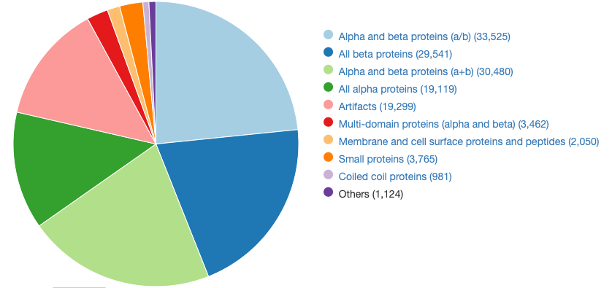

3) The proteins in the PDB come from species that people were interested in studying; for example, there are far more human structures than any other species in the PDB:

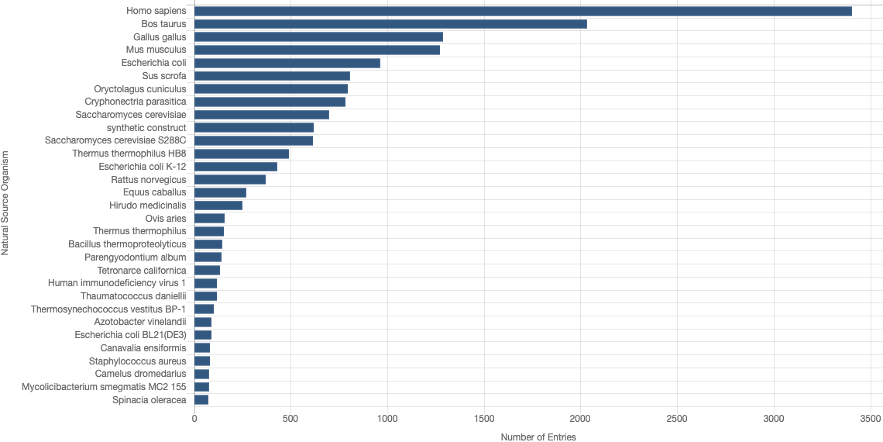

All of this means that there are A LOT of highly similar protein sequences in the PDB, and this can obviously be a problem when training our model.

In order to mitigate these effects, the PDB sequences are clustered based on the level of similarity in their amino acid sequences. Each protein is assigned to a cluster if they are X% similar to a representative sequence from that cluster. In the dataset we will use today, that threshold is 50%.





In [21]:
# Read in the dataset

full_dataset = datasets.load_dataset("json", data_files = dset_path)

full_dataset

DatasetDict({
    train: Dataset({
        features: ['prot2_labels', 'prot1_labels', 'clus2', 'id', 'clus1', 'prot2_seq', 'prot1_seq'],
        num_rows: 50000
    })
})

In [22]:
print(full_dataset["train"][0]["id"])
print(full_dataset["train"][0]["clus1"])
print(full_dataset["train"][0]["clus2"])
print(full_dataset["train"][0]["prot1_seq"])
print(full_dataset["train"][0]["prot2_seq"])
print(full_dataset["train"][0]["prot1_labels"])
print(full_dataset["train"][0]["prot2_labels"])

6OCO.gz_B_A
37333
20570
YQQDQVVKEDNIEAVGKKLHEYNTQFQEKSREYDRLYEDYTRTSQEIQMKRTAIEAFNETIKIFEEQCQTQERYSKEYIEKFKREGNETEIQRIMHNYEKLKSRISEIVDSRRRLEEDLKKQAAEYREIDKRMNSIKPDLIQLRKTRDQYLMWLTQKGVRQKKLNEWLGN
NQSVVVDFLLPTGVYLNFPVSRNANLSTIKQLLWHRAQYEPLFHMLSGPEAYVFTCINQTAEQQELEDEQRRLCDVQPFLPVLRLVAREGDRVKKLINSQISLLIGKGLHEFDSLCDPEVNDFRAKMCQFCEEAAARRQQLGWEAWLQYSFPLQLEPSAQTWGPGTLRLPNRALLVNVKFEGSEESFTFQVSTKDVPLALMACALRKKATVFRQPLVEQPEDYTLQVNGRHEYLYGSYPLCQFQYICSCLHSGLTPHLTMVHSSSILAMRDEQSNPAPQVQKPRAKPPPIPAKKPSSVSLWSLEQPFRIELIQGSKVNADERMKLVVQAGLFHGNEMLCKTVSSSEVSVCSEPVWKQRLEFDINICDLPRMARLCFALYAVIEKAKKARSTKKKSKKADCPIAWANLMLFDYKDQLKTGERCLYMWPSVPDEKGELLNPTGTVRSNPNTDSAAALLICLPEVAPHPVYYPALEKILELGRHSECVHVTEEEQLQLREILERRGSGELYEHEKDLVWKLRHEVQEHFPEALARLLLVTKWNKHEDVAQMLYLLCSWPELPVLSALELLDFSFPDCHVGSFAIKSLRKLTDDELFQYLLQLVQVLKYESYLDCELTKFLLDRALANRKIGHFLFWHLRSEMHVPSVALRFGLILEAYCRGSTHHMKVLMKQGEALSKLKALNDFVKLSSQKTPKPQTKELMHLCMRQEAYLEALSHLQSPLDPSTLLAEVCVEQCTFMDSKMKPLWIMYSNEEAGSGGSVGIIFKNGDDLRQDMLTLQMIQLMDVLWKQEGLDLRMTPYGCLPTGDR

The "id" field is in the format: \<PDB ID\>.gz_\<protein sequence 1 chain identifier\>_\<protein sequence 2 chain identifer\>. The "clus1" and "clus2" fields contain the ID of the cluster that each protein sequence was assigned to. The amino acid sequences of each protein ar in "prot1_seq" and "prot2_seq". Finally, the label for each amino acid in each protein sequence (0 for non-interfacial, 1 for interfacial) is in "prot1_labels" and "prot2_labels".

Although training models using X-fold cross validation often results in better outcomes, for the sake of time/calculation efficiency we are going to use a single training, validation, and test set today.

In [23]:
temp_split = full_dataset["train"].train_test_split(test_size = 0.5, seed = 424242) # We will use 50% of the data for training, 30% for validation, and 20% for testing
final_split = temp_split["test"].train_test_split(test_size = 0.3, seed = 424242)

ppi_ds = datasets.DatasetDict({
    "train": temp_split["train"],
    "test": final_split["test"],
    "valid": final_split["train"] # We use "train" here because the Dataset train_test_split function returns two dictionaries labeled "train" and "test"
})

ppi_ds

DatasetDict({
    train: Dataset({
        features: ['prot2_labels', 'prot1_labels', 'clus2', 'id', 'clus1', 'prot2_seq', 'prot1_seq'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['prot2_labels', 'prot1_labels', 'clus2', 'id', 'clus1', 'prot2_seq', 'prot1_seq'],
        num_rows: 7500
    })
    valid: Dataset({
        features: ['prot2_labels', 'prot1_labels', 'clus2', 'id', 'clus1', 'prot2_seq', 'prot1_seq'],
        num_rows: 17500
    })
})

## Tokenizing Data

We now need to tokenize the data in preparation for fine-tuning our model. The pre-trained model we will be using is called "ESM-2". "ESM" stands for "evolutionary scale modeling", and was created by Meta's Fundamental AI Research Protein Team. (See [here](https://www.science.org/doi/full/10.1126/science.ade2574) for more details.)

This model has a max token length of 1024, which is too short for a lot of protein sequence pairs.

2019


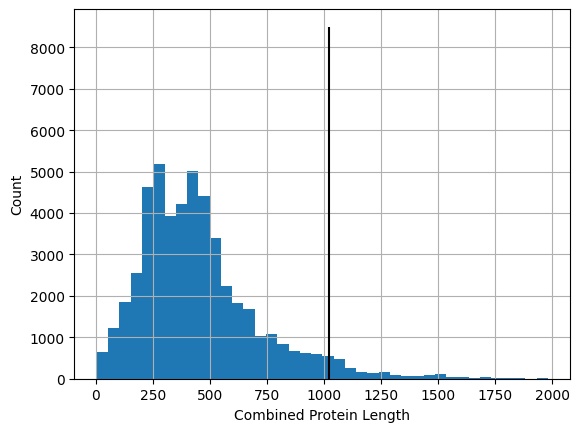

In [24]:
# Visualize the sequence lengths in the data
import matplotlib.pyplot as plt

# Doing this with the json file because it takes
# a very long time to do this on the dataset object
import json
with open("/Users/cmann/Downloads/t5_c50_50000_dataset.json", "r") as f:
    conts = json.load(f)

# Get the lengths of each pair of protein sequences
l1 = [len(conts[i]["prot1_seq"]) for i in range(len(conts))]
l2 = [len(conts[i]["prot2_seq"]) for i in range(len(conts))]
lt = [l1[i] + l2[i] for i in range(len(l1))]

# Count the number of combined protein lengths >= 1021
# (because three tokens have to be added to each sequence)
c = 0
for l in lt:
    if l > 1021:
        c += 1
print(c)

# Show the combined length distribution
plt.grid(True, which = "both")
plt.hist(lt, bins = 40)
plt.vlines(1024, 0, 8500, color = "black")
plt.xlabel("Combined Protein Length")
plt.ylabel("Count")
plt.show()

In order to get around this, we're going to do a somewhat ugly hack to allow sequences of up to length 2048 (including the "punctuation" tokens.) We will drop any sequences from the dataset that are longer than this later during pre-processing (there are no examples in this dataset that will be longer than this token length).

The hack in question is to make our own custom ESM class, and force this class to use our 2048 max token length.

NOTE: Modifying models others have pre-trained in this manner comes with some risk. Drastically increasing the token length can (in some cases, massively) impact model performance, as the model's attention mechanisms weren't trained to learn on that length of distance. In this case, after extensive experimentation (not shown here) this hack does work in this use case, but the fine-tuned models produced from that experimentation do predict the interacting residues for the first protein in the sequence than the second.

In [25]:
class CustomEsmForTokenClassification(transformers.EsmForTokenClassification):
    def __init__(self, config):
        super().__init__(config)
        self.esm.embeddings.position_embeddings = torch.nn.Embedding(2048, config.hidden_size)
        self.esm.embeddings.register_buffer(
          "position_ids", torch.arange(2048).expand((1, -1)), persistent=False
    )

In [26]:
# Load the Huggingface tokenizer for ESM2
# We will use the 8 million parameter model for quicker training, but there are much larger ESM models

tokenizer = transformers.AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D", do_lower_case = False, is_split_into_words = True)
tokenizer.model_max_length = 2048

# We give the "is_split_into_words" argument the value "True" because we need to do a little bit of additional pre-processing
# to the dataset that will result in the amino acid sequences being split into "words" - i.e, instead of a single string,
# we will have a list of characters.

## Dataset Processing

Now we will make a function to pre-process the dataset. This function will take the two amino acid sequences, convert them into tokens, concatenate them using a "\<sep\>" token, and add start and end tokens. It will also take the labels, concatenate them, and add the label "-100" at the positions of the \<sep\> and start/end tokens to indicate that the model shouldn't pay attention to those tokens when labeling.

In [27]:
# Function to take a string and split it into a list of characters
def split_into_tokens(string):
    rs = list(string)
    rs = [s for s in string if s != ' ']
    return(rs)

# Fix the labels for named entity recognition (token classification)
def make_ner_tags(prot1_labels, prot2_labels):
    ner_labels = [-100] # For the start token
    ner_labels = ner_labels + prot1_labels
    ner_labels.append(-100) # For the separator token between the two protein sequences
    ner_labels = ner_labels + prot2_labels
    ner_labels.append(-100) # For the end token
    # Convert the character string labels to ints
    ner_labels = [int(n) for n in ner_labels]
    return(ner_labels)

# Preprocess function that will be applied to each example in the dataset
def preprocess_fn(examples):

    # Split the protein sequences into character lists
    prot1_seq = [split_into_tokens(p) for p in examples["prot1_seq"]]
    prot2_seq = [split_into_tokens(p) for p in examples["prot2_seq"]]

    # Format the NER labels
    ner_tags = [make_ner_tags(examples["prot1_labels"][i], examples["prot2_labels"][i]) for i in range(len(examples["prot1_labels"]))]

    # Tokenize the input sequences
    inputs = tokenizer(prot1_seq, prot2_seq)
    inputs["labels"] = ner_tags

    return(inputs)


# Now apply the preprocess function to the dataset; have to remove the column names because
# models can get very cranky if you don't
tkn_ppi_ds = ppi_ds.map(preprocess_fn, batched = True, num_proc = 1, remove_columns = ppi_ds["train"].column_names)

tkn_ppi_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17500
    })
})

In [28]:
print(tkn_ppi_ds["train"][0]["input_ids"])
print(tkn_ppi_ds["train"][0]["attention_mask"])
print(tkn_ppi_ds["train"][0]["labels"])

[0, 10, 9, 23, 15, 11, 9, 8, 17, 11, 18, 14, 6, 12, 23, 12, 11, 15, 14, 14, 23, 10, 15, 5, 23, 12, 8, 9, 15, 18, 11, 13, 6, 21, 23, 8, 15, 12, 4, 10, 10, 23, 4, 23, 11, 15, 14, 23, 2, 10, 9, 23, 15, 11, 9, 8, 17, 11, 18, 14, 6, 12, 23, 12, 11, 15, 14, 14, 23, 10, 15, 5, 23, 12, 8, 9, 15, 18, 11, 13, 6, 21, 23, 8, 15, 12, 4, 10, 10, 23, 4, 23, 11, 15, 14, 23, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-100, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, -100, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, -100]



The "attention_mask" parameter here tells the model which tokens should be included when it is doing its calculations. The values are zero for padding tokens. Since we have not padded any of our sequences, currently all of the attention masks are 1s. Rather than padding all of the sequences to 2048 tokens at the start, we will use dynamic padding so that sequences are padded per batch, which saves an enormous amount of memory.


Next we will make a data collator, which will be responsible for handling packaging the data to hand to the model.


In [29]:
# Create the data collator

data_collator = transformers.DataCollatorForTokenClassification(tokenizer = tokenizer)

## Setting up the Model

Now we need a way of assessing the model's performance when making predictions, so we will make a function to compute various metrics. We will use Huggingface's metrics, and will use sequence evaluation metrics implemented by the seqeval package.

NOTE: Some prediction metrics may be ill-defined, depending on the training data and model performance. If the model (incorrectly) predicts that all residues in the two sequences are non-interacting, this will result in precision, recall, and F1 having a division by zero in their calculation (as they are calculated by taking the mean of the per-class precision, recall, and F1 score.) 

In [30]:
# Make the metric
metric = evaluate.load("seqeval")

def compute_metrics(preds):
    logits, labels = preds

    # Gets the class label from the logits
    predictions = np.argmax(logits, axis = -1)

    # Exclude the labels predicted for the start/end/sep tokens, since we don't actually
    # care if the model can correctly predict -100 for these
    # Also have to convert the labels to strings, because metric.compute expects the class
    # labels to be strings and not ints
    labels = [[str(l) for l in label if l != -100] for label in labels]
    preds  = [[str(p) for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    metrics = metric.compute(predictions = preds, references = labels)

    metric_dict = {
      "precision": metrics["overall_precision"],
      "recall": metrics["overall_recall"],
      "f1": metrics["overall_f1"],
      "accuracy": metrics["overall_accuracy"]
    }

    return(metric_dict)


Now we will actually set up our transformer for training.

In [31]:
# Set a seed for reproducibility
transformers.set_seed(424242)

# Get the model's current configuration, so that we can give this configuration
# to the custom model class we will implement
mconfig = transformers.models.esm.configuration_esm.EsmConfig.from_pretrained("facebook/esm2_t6_8M_UR50D", ignore_mismatched_sizes = True)

# Change the max length parameter in the config to use our 2048 token length
mconfig.max_position_embeddings = 2048

# Now create an implementation of our custom class
model = CustomEsmForTokenClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", config = mconfig, ignore_mismatched_sizes = True)
print(model.config)

Some weights of CustomEsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CustomEsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized because the shapes did not match:
- esm.embeddings.position_embeddings.weight: found shape torch.Size([1026, 320]) in the checkpoint and torch.Size([2048, 320]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmConfig {
  "_name_or_path": "facebook/esm2_t6_8M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 2048,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.39.2",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}



Now we will set up the parameters for training our model.

First, create a folder in the Colab directory to store the training run(s) in. I called mine "training_runs". Copy the path to this folder as the first argument for training_args.

Most arguments are described in the comments, but the "per_device_train_batch_size" and "gradient_accumulation_steps" deserve some discussion. This model is prone to throwing OOM errors on a Tesla V100-SXM2 with 32GB with larger batch sizes. To compensate for this, we can use a smaller batch size and then specify a larger value for gradient_accumulation_steps. The overall effect here is to essentially spread out the memory hit of training a single batch. If you wanted a batch size of 64, for example, you would set your per_device batch size multiplied by the gradient_accumulation_steps to be equal to that batch size. We use 2 and 32 in the configuration below.

In [34]:
training_args = transformers.TrainingArguments(
  storage_path, # Path to where the model(s) will be saved
  evaluation_strategy = "epoch", # Evaluate the model after the end of every epoch
  save_strategy = "epoch", # Save the model after every epoch
  learning_rate = 1e-3, # Learning rate
  num_train_epochs = 10, # Number of epochs to train the model for; I have found these models will generally plateau within 10 epochs
  per_device_train_batch_size = 2,
  gradient_accumulation_steps = 64,
  per_device_eval_batch_size = 2,
  weight_decay = 0,
  dataloader_num_workers = 2 # You can play around with this a lot to optimize the speed of the model loading the data
  # Too many and the model speed drops from running the coordination
)

In [35]:
trainer = transformers.Trainer(
    model = model,
    args = training_args,
    train_dataset = tkn_ppi_ds["train"],
    eval_dataset  = tkn_ppi_ds["valid"],
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    tokenizer = tokenizer,
)

In [ ]:
# Note: Unless your GPU has 32+ GB memory, this is likely to crash with an out-of-memory error
trainer.train()

## Training the Model

After creating the training artguments and creating a trainer to control the training run, we can now instantiate and run the entire training loop by simply running ```trainer.train()```

However, this can take a long time to run, and is very likely to crash unless you have a GPU with 32GB+ memory. We have also provided a pre-trained version of this toy model so that you don't have to wait for training to experiment with it. (This model was trained using a slightly earlier version of transformers and datasets, so results may vary slightly from what you train yourself.)

In [37]:
# Load the pre-trained model
model = CustomEsmForTokenClassification.from_pretrained(model_path, ignore_mismatched_sizes = True)

## Assessing the Model

Determining "how well" a model is performing depends on a lot of factors, the most important being - what is the ultimate purpose of your model? This model's purpose is obviously predicting the interacting residues between two interacting protein sequences, but we need to consider WHY we want to do that in the first place.

In my case, I am interested in ultimately using models like this for predicting where an antibody will bind to its target. So I am ultimately much more interested in how well the model can correctly identify the residues that interact. Thus, I am interested in models that have high sensitivity/recall (correctly identifying the interacting class), rather than models that have the highest overall accuracy (which is also fairly meaningless in this example, as there are FAR more examples of the non-interacting class than the interacting one in both training and test sets, so the model can get very high accuracy by simpling predicting that all residues are non-interacting.)

I am not, however, training models using sensitivity/recall as the loss metric, as I do still care about minimizing false positives and sensitivity/recall doesn't take false positives into account in its calculation:

sensitivity, aka recall = total number of true positives / (total number of true positives + total number of false negatives)


Instead, the model's training adjustments are made based on cross-entropy loss, which does take into account minimizing the false positives.

We can see the accuracy and cross-entropy loss in the logs for our trainer.

To assess the model, we can now test it on our held-out test set. Since I am interested in not just the overall performance, but how well the model predicts for each protein sequence, I want to break down the calculation metrics per sequence.

In [50]:
# Get the label from the logits
def get_pred_labels(tensor_preds):
    pred_labels = []
    for i in range(len(tensor_preds)):
        if tensor_preds[i][0] > 0.5:
            pred_labels.append(0)
        else:
            pred_labels.append(1)
    return(pred_labels)

# Function to take model predictions and calculate performance metrics
def process_output(outputs, batch):
    tp, tn, fp, fn = [], [], [], []
    
    # Take the batch of predicted logits and convert them into their respective labels
    pred_labels = [get_pred_labels(torch.nn.functional.softmax(outputs[1].detach().cpu(), dim = -1).numpy()[i]) for i in range(len(outputs[1]))]

    # Get the actual labels for all the sequences in the batch
    batch_labels = [list(np.array(batch["labels"][i].detach().cpu())) for i in range(len(batch["input_ids"]))]
    
    # Convert the input token ids back into the protein sequence, and get the individual protein sequences
    decoded = [tokenizer.decode(b) for b in batch["input_ids"]]
    prot1 = [d.split("<eos>")[0].replace("<cls>", "").replace(" ", "") for d in decoded]
    prot2 = [d.split("<eos>")[1].replace(" ", "") for d in decoded]

    # Replace the "unknown token" (<unk>) with an "X" - this crops up when there is a non-canonical
    # amino acid in the sequence, e.g. selenocysteine or something more exotic.
    prot1 = [p.replace("<unk>", "X") for p in prot1]
    prot2 = [p.replace("<unk>", "X") for p in prot2]
    
    # Turn this into a pandas dataframe for easier handling and filtering
    pdf = pd.DataFrame(zip(pred_labels, batch_labels, prot1, prot2))
    pdf.columns = ["preds", "labels", "prot1", "prot2"]
    
    prot1_l, prot2_l, pred1_l, pred2_l, label1_l, label2_l = [], [], [], [], [], []
    
    # Now go through and break down teh predictions for each protein in the pair of sequences
    for i in range(len(pdf)):
        # Make a temporary dataframe to hold the contents of the other dataframe
        tdf = pd.DataFrame(zip(pdf.preds[i], pdf.labels[i]), columns = ["preds", "labels"])

        # Get the predicted labels
        preds = pdf.preds[i]
        labels = pdf.labels[i]

        # Get the label indices that are part of each sequence
        l1 = len(pdf.prot1[i])
        l2 = len(pdf.prot2[i])

        pred1 = preds[1 : 1+l1]
        pred2 = preds[1+l1+1 : 1+l1+1+l2]
        label1 = labels[1 : 1+l1]
        label2 = labels[1+l1+1 : 1+l1+1+l2]

        # Because we don't care about the model's performance when predicting classes for <eos> and <cls> tokens,
        # remove those tokens whose batch labels are -100 from consideration
        tdf_n100 = tdf[tdf.labels != -100]

        # Now get the number of true positives, true negatives, false positives, and false negatives for the overall prediction
        tp.append(len(tdf_n100[(tdf_n100.preds == 1) & (tdf_n100.labels == 1)]))
        tn.append(len(tdf_n100[(tdf_n100.preds == 0) & (tdf_n100.labels == 0)]))
        fp.append(len(tdf_n100[(tdf_n100.preds == 1) & (tdf_n100.labels == 0)]))
        fn.append(len(tdf_n100[(tdf_n100.preds == 0) & (tdf_n100.labels == 1)]))

        # Store this information for return
        prot1_l.append(pdf.prot1[i])
        prot2_l.append(pdf.prot2[i])
        pred1_l.append(pred1)
        pred2_l.append(pred2)
        label1_l.append(label1)
        label2_l.append(label2)
        
    # Make dataframe
    ret_frame = pd.DataFrame(zip(prot1_l, prot2_l, pred1_l, pred2_l, label1_l, label2_l, tp, tn, fp, fn), columns = ["Prot1", "Prot2", "Preds1", "Preds2", "Labels1", "Labels2", "TP", "TN", "FP", "FN"])
    return(ret_frame)

Now we can use a dataloader to feed our test set to the model and get predictions on those sequences:

In [75]:
# Make a dataloader to feed the test data to the model; we can use the same data collator as before
# Note - this may take a while to run - if it takes too long, you can make a smaller split of the test set
# Uncomment the code below here marked with #*, and comment out the code with a ## at the end of the line, 
# to run on a subset of just 50 of the test set examples

# This odd little workaround is necessary because tkn_ppi_ds["test"][0:50] is a dictionary, and not 
# a dataset, so we need to convert it back to a dataset.
test_subset = datasets.Dataset.from_pandas(pd.DataFrame(data = tkn_ppi_ds["test"][0:100])) #*

dataloader_params = {
            "batch_size": 8,
            "collate_fn": data_collator,
            "num_workers": 1,
            "pin_memory": True,
        }

#dataloader = torch.utils.data.DataLoader(tkn_ppi_ds["test"], **dataloader_params) ##
dataloader = torch.utils.data.DataLoader(test_subset, **dataloader_params) #*

# Set the model into evaluate mode
model.eval()

# Now have the models run predictions on our test data:
r_frames = [] # Store the outputs

# Use a GPU to do the inference if a CUDA-supported GPU is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for batch in dataloader:
        outputs = model(**batch.to(device))
        r_frames.append(process_output(outputs, batch))

r_frame = pd.concat(r_frames) # Group the outputs

With this, we can now get the sensitivity/recall, precision, F1 score, and accuracy:

In [77]:
TP = r_frame.TP.sum()
TN = r_frame.TN.sum()
FP = r_frame.FP.sum()
FN = r_frame.FN.sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

print(accuracy)
print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

0.9249454475697192
0.4296774193548387
0.9756793909273554
0.6441005802707931
0.5154798761609908


While 43% sensitivity is nothing to write a journal about, keep in mind that this model was trained on just 25,000 examples, and tested on 7,500. In the test dataset (which should be very close to the training dataset in proportions), we can see that the total number of interacting residues in the dataset is 3,875 (TP + FN), and the number of non-interacting residues is 37,828 (TN + FP):

In [81]:
print("Interacting residue count: " + str(TP + FN))
print("Non-interacting residue count: " + str(TN + FP))
print("Proportion of interacting residues: " + str((TP + FN)/(TP + FN + TN + FP)))

Interacting residue count: 3875
Non-interacting residue count: 37828
Proportion of interacting residues: 0.09291897465410162


We can estimate how many residues a model would correctly classify if it was simply guessing as to whether or not a residue is interacting by assigning a label based on the observed class proportions - i.e., by guessing "interacting" for ~9% of residues, and non-interacting for the rest. We can simulate this by generating a list of "interacting" and "non-interacting" residues in the proportions above, and then generating a second list with the same proportions, and comparing how many times the two lists match.

In [95]:
import random

def generate_random_list(int_prop, length):
    count_ones = round(length * int_prop)
    count_zeros = length - count_ones

    # Make a list of the correct number of ones and zeros
    ret_list = ([1] * count_ones) + ([0] * count_zeros)

    # Then mix them all up
    random.shuffle(ret_list)
    return(ret_list)

TP_l, TN_l, FP_l, FN_l = [], [], [], []

# Do this a bunch of times so we have a better estimate
iterations = 100
for _ in range(iterations):
    # Make the lists
    list1 = generate_random_list(0.0929, 37828)
    list2 = generate_random_list(0.0929, 37828)

    # Now compare how many of the "interacting" and non-interacting classes were predicted correctly
    TP_count = sum(x == 1 and y == 1 for x, y in zip(list1, list2))
    TN_count = sum(x == 0 and y == 0 for x, y in zip(list1, list2))
    FN_count = sum(x == 1 and y == 0 for x, y in zip(list1, list2))
    FP_count = sum(x == 0 and y == 1 for x, y in zip(list1, list2))

    TP_l.append(TP_count)
    TN_l.append(TN_count)
    FN_l.append(FN_count)
    FP_l.append(FP_count)
    
# Calculate the average counts of the number of correctly predicted interacting vs non-interacting
average_TP = sum(TP_l) / iterations
average_TN = sum(TN_l) / iterations
average_FN = sum(FN_l) / iterations
average_FP = sum(FP_l) / iterations

a_precision = average_TP / (average_TP + average_FP)
a_sensitivity = average_TP / (average_TP + average_FN)

print("Average True Positive count:" + str(average_TP))
print("Average True Negative count:" + str(average_TN))
print("Sensitivity: " + str(a_sensitivity))
print("F1_Score: " + str(2 * (a_precision * a_sensitivity) / (a_precision + a_sensitivity)))

Average True Positive count:324.35
Average True Negative count:31124.35
Sensitivity: 0.09230221969265795
F1_Score: 0.09230221969265795


As a reminder, this is how many the model trained on just 25000 examples gets correct:

In [91]:
print("Correctly predicted interacting class: " + str(TP))
print("Correctly predicted non-interacting class: " + str(TN))

Correctly predicted interacting class: 1665
Correctly predicted non-interacting class: 36908


Our models trained on larger datasets frequently achieve >0.8 sensitivity.